In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Face Mask Detector

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

#### Initial Hyperparams

In [4]:
INIT_LR = 1e-4
EPOCHS = 8
BS = 32

In [5]:
DIRECTORY = "/kaggle/input/face-mask-detection/Dataset/"
CATEGORIES = ["with_mask", "without_mask"]

data = []
labels = []

#### Seperate labels and images

In [7]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY,category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(244,244))
        image = img_to_array(image)
        image = preprocess_input(image) #PP req for mobile_net
        
        data.append(image)
        labels.append(category)

#### One hot encoding all the labels

In [8]:
#Binarize labels in a one-vs-all fashion
Label_Bi = LabelBinarizer()
labels = Label_Bi.fit_transform(labels)
labels = to_categorical(labels)

#numpy conversion
data = np.array(data, dtype="float32")
labels = np.array(labels)

#### Split training and testing data

In [11]:
(X_train, X_test, Y_train, Y_test) = train_test_split(data,
    labels,test_size=0.20, stratify = labels, random_state = 42)


#### Initiate the Image data generator

In [12]:
AugmentedData = ImageDataGenerator(
            	rotation_range=20,
            	zoom_range=0.15,
            	width_shift_range=0.2,
            	height_shift_range=0.2,
            	shear_range=0.15,
            	horizontal_flip=True,
            	fill_mode="nearest")

#### Use MobileNet V2 with the 'imagenet' weights to be used as the base model

In [13]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, 
                        input_tensor= Input(shape=(244, 244, 3)))

9406464/9406464 [==============================] - 0s 0us/step


#### Use a simple CNN as the Head model

In [14]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)

headModel = Flatten()(headModel)
headModel = Dense(128,activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
fusedModel = Model(inputs= baseModel.input, outputs= headModel)

#### freeze MobileNet V2 layers, so only the headmodel can train on the data, while the base model can use the previously trained weights

In [16]:
for layer in baseModel.layers:
    layer.trainable = False

#### Initiate Adam optimizer

In [17]:
optimized = tf.keras.optimizers.legacy.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

In [18]:
#Compile the model
fusedModel.compile(loss="binary_crossentropy", optimizer=optimized,
	metrics=["accuracy"])

In [19]:
#Model.fit() gets the model to fit into the given data
H = fusedModel.fit(
	AugmentedData.flow(X_train, Y_train, batch_size=BS),
	steps_per_epoch=len(X_train) // BS,
	validation_data=(X_test, Y_test),
	validation_steps=len(X_test) // BS,
	epochs=EPOCHS)

Epoch 1/8
149/149 [==============================] - 71s 423ms/step - loss: 0.3744 - accuracy: 0.8501 - val_loss: 0.1484 - val_accuracy: 0.9432
Epoch 2/8
149/149 [==============================] - 60s 406ms/step - loss: 0.1767 - accuracy: 0.9395 - val_loss: 0.1112 - val_accuracy: 0.9533
Epoch 3/8
149/149 [==============================] - 62s 416ms/step - loss: 0.1363 - accuracy: 0.9525 - val_loss: 0.0926 - val_accuracy: 0.9633
Epoch 4/8
149/149 [==============================] - 62s 419ms/step - loss: 0.1221 - accuracy: 0.9578 - val_loss: 0.0857 - val_accuracy: 0.9658
Epoch 5/8
149/149 [==============================] - 62s 416ms/step - loss: 0.1116 - accuracy: 0.9617 - val_loss: 0.0768 - val_accuracy: 0.9725
Epoch 6/8
149/149 [==============================] - 60s 403ms/step - loss: 0.1029 - accuracy: 0.9643 - val_loss: 0.0715 - val_accuracy: 0.9783
Epoch 7/8
149/149 [==============================] - 62s 414ms/step - loss: 0.0956 - accuracy: 0.9668 - val_loss: 0.0700 - val_accuracy:

In [20]:
print(">>> Generating Test predictions")
predicted_Index = fusedModel.predict(X_test, batch_size=BS)

>>> Generating Test predictions
38/38 [==============================] - 2s 39ms/step


In [21]:

#In context, for each image evaluated, we obtain the index of the highly 
# probable label for that image.

predicted_Index = np.argmax(predicted_Index, axis=1)

#Build a text report showing the main classification metrics.
print(classification_report(Y_test.argmax(axis = 1), predicted_Index, 
                            target_names= Label_Bi.classes_))



              precision    recall  f1-score   support

   with_mask       0.97      0.99      0.98       599
without_mask       0.99      0.97      0.98       599

    accuracy                           0.98      1198
   macro avg       0.98      0.98      0.98      1198
weighted avg       0.98      0.98      0.98      1198



In [23]:
#Model.Save(): It saves data of the model ina serialized manner.
fusedModel.save("/kaggle/working/mask_detector.model", save_format="h5")

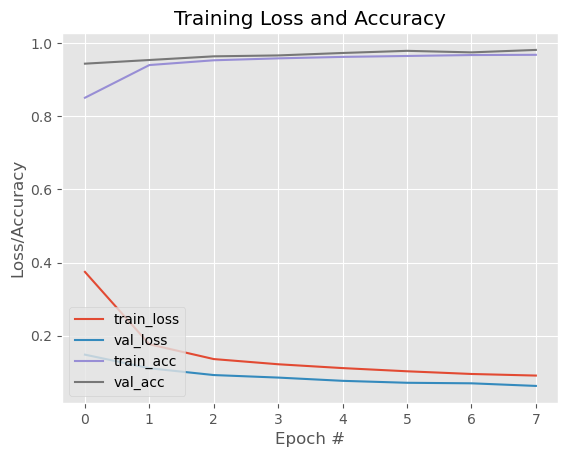

In [22]:

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")


### Conclusion

The model acheived 97% and 98% accuracy on training and test data respectively, with very minimal loss. This shows the power of transfer learning, where a simple model along with a general model can leverage better accuracy in just a few epochs of training.